In [1]:
# package loading
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [2]:
# Data generation
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
y2 = y2 + 2
X2 = X2 + [6, -8]

X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [3]:
np.unique(y)

array([0, 1, 2])

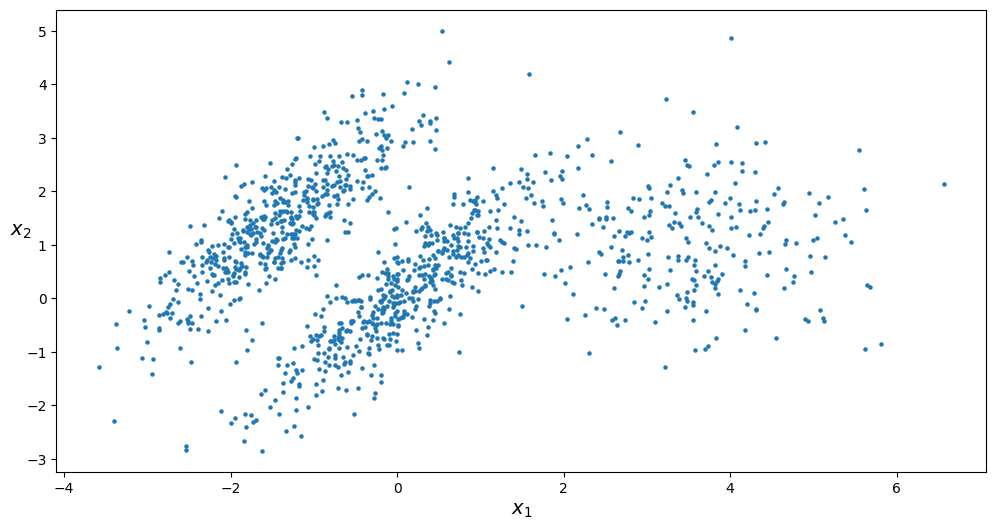

In [4]:
# visualize the data
def plot_clusters(X, y=None):

    plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.figure(figsize=(12, 6))
plot_clusters(X)
plt.show()

In [5]:
# GMM train
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

In [6]:
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):

    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]

    # alpha: blending value, between 0 (transparent) and 1 (opaque)
    # zorder: layer 위치
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)

    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=5,
                color=cross_color, zorder=11, alpha=1)

In [7]:
def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):

    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1

    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0), # for contour color
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)

    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

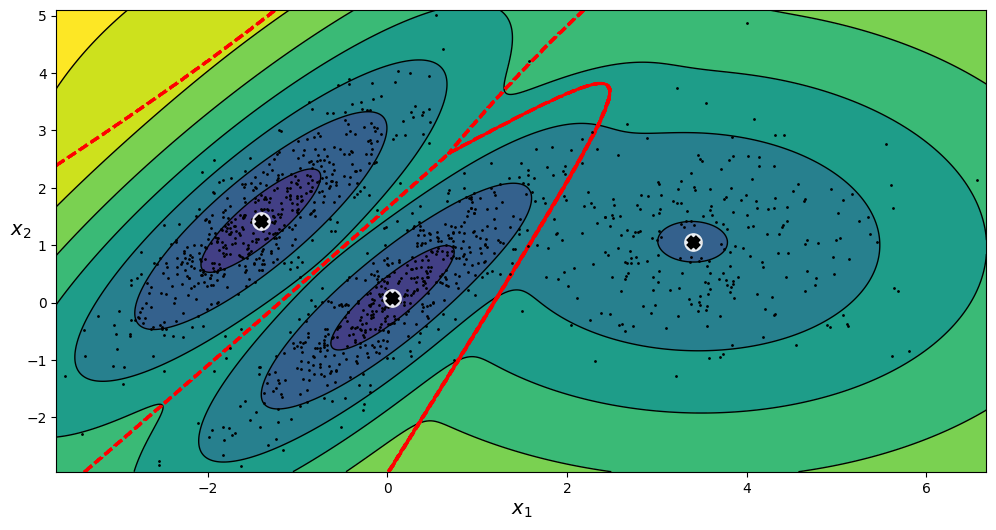

In [8]:
# visualize the result
plt.figure(figsize=(12, 6))

plot_gaussian_mixture(gm, X)

plt.show()

# Selecting the Optimal Number of Clusters: AIC, BIC

  * 3개 샘플(x1, x2, x3)은 주황색 분포에서 더 높은 확률로 관측될 수 있음
  * likelihood가 가장 높은 순간을 찾고자 하는 것이 "maximum likelihood estimation (MLE)"임
  * GMM은 likelihood 성질을 이용해 최적의 파라미터를 찾고, 해당 분포를 기반으로 최적의 클러스터 수를 예측함

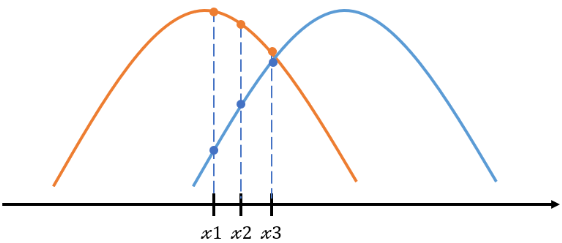

Bayesian information criterion (BIC) 혹은 Akaike information criterion (AIC) 값을 기준으로 최적의 모델 탐색이 가능함.

BIC, AIC: penalized-likelihood criteria
- AIC is an estimate of a constant plus the relative distance between the unknown true likelihood function of the data and the fitted likelihood function of the model. So, a lower AIC means a model is considered to be closer to the truth.
- BIC is an estimate of a function of the posterior probability of a model being true, under a certain Bayesian setup. So, a lower BIC means that a model is considered to be more likely to be the true model.

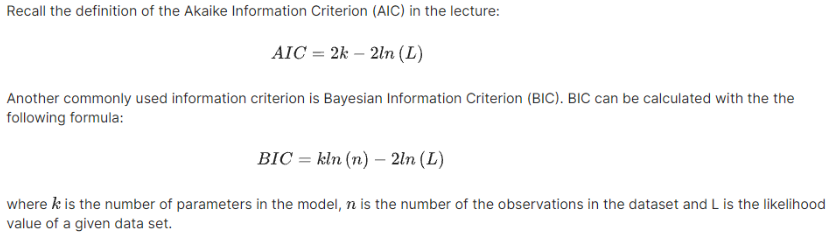

-------
* AIC, BIC 최소화의 의미: 우도(likelihood)를 가장 크게 하는 동시에, 변수 갯수는 가장 적은 최적의 모델을 선택하는 것

* BIC의 경우, 변수가 많을수록 AIC보다 패널티를 크게 가하는 특성이 있음

* BIC가 AIC 보다 변수 증가에 더 민감하기 때문에, 변수 갯수가 적은 것이 우선적으로 고려되어야 한다면 BIC를 기준으로 삼는 것이 좋음

In [9]:
n_clusters = 3
n_dims = 2

n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2

# GMM에 사용되는 전체 파라미터 수
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
print(n_params)

17


In [10]:
# "ccore" method computes the per-sample average log-likelihood of the given data X

max_log_likelihood = gm.score(X) * len(X)
max_log_likelihood

-4034.260860191074

In [11]:
# BIC and AIC copmutation
# AIC, BIC 최소화 한다는 것은 likelihood를 크게 함과 동시에 변수의 갯수는 가장 적은 최적의 모델을 선택한다는 것을 의미함
# 변수의 갯수가 적어야 하는 것에 우선순위를 둔다면, BIC를 사용하는 것이 효과적

bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

print("BIC: ", bic)
print("AIC: ", aic)

BIC:  8189.747000497186
AIC:  8102.521720382148


In [12]:
# Train GMM with various values of k
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

print("BIC:", bics)
print("AIC:", aics)

BIC: [9330.418496222055, 8971.197133122107, 8189.747000497186, 8229.595643711533, 8273.78524672955, 8311.996155416307, 8350.89457398886, 8391.038436209936, 8432.267971405674, 8465.222274137557]
AIC: [9304.764002070573, 8914.757245988847, 8102.521720382148, 8111.584970614717, 8124.989180650957, 8132.414696355936, 8140.52772194671, 8149.886191186008, 8160.3303333999675, 8162.499243150073]


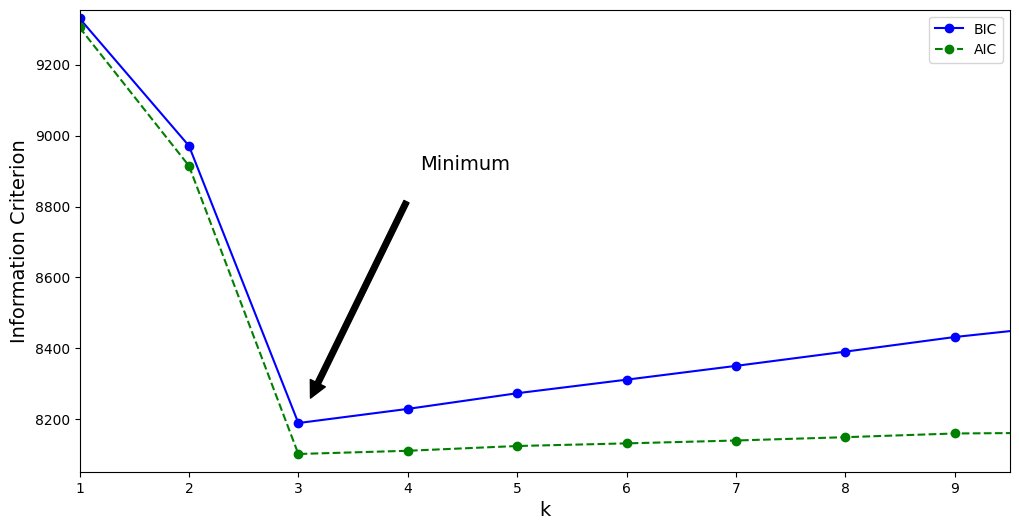

In [13]:
# visualize the BICs and AICs
plt.figure(figsize=(12, 6))

plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")

plt.xlabel("k", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]), # 화살이 가리키는 위치
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1) # shrink: 텍스트로부터 얼마나 떨어진 위치에서 화살표가 시작하는가? (0-1 사이)
            )
plt.legend()
plt.show()

In [14]:
# BIC scores (automation)
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

param_grid = {
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(n_components=3, n_init=10, random_state=42), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(X)

GridSearchCV(estimator=GaussianMixture(n_components=3, n_init=10,
                                       random_state=42),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full']},
             scoring=<function gmm_bic_score at 0x795a6d485bd0>)

In [15]:
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_covariance_type", "mean_test_score"]]

df["mean_test_score"] = -df["mean_test_score"]

df = df.rename(
    columns={
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

,Type of covariance,BIC score
0,spherical,2419.435383
2,diag,2616.244956
3,full,3335.133277
1,tied,4231.266533


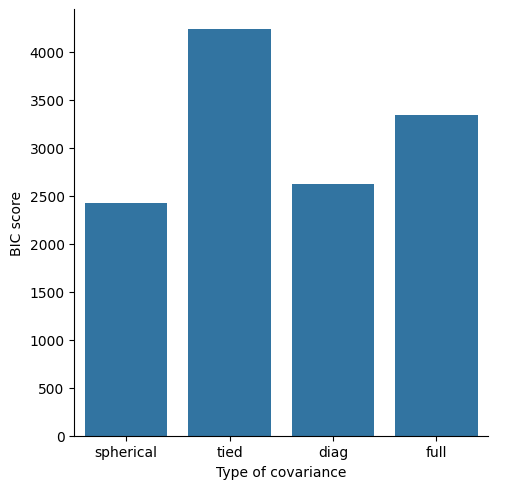

In [16]:
import seaborn as sns

sns.catplot(
    data=df,
    kind="bar",
    x="Type of covariance",
    y="BIC score"
)
plt.show()

In [17]:
# optimal GMM training

gm_optimal = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42).fit(X)
gm_optimal_pred = gm.fit_predict(X)

# performance check
pd.DataFrame(gm_optimal_pred)[0].value_counts()

0    501
1    501
2    248
Name: 0, dtype: int64

In [18]:
# comparison with labels
pd.DataFrame(y)[0].value_counts()

1    500
0    500
2    250
Name: 0, dtype: int64